In [1]:
library(rlang)
library(repr)
library(tidyverse)
options(repr.plot.width=8, repr.plot.height=4)
library(xtable)
library(latex2exp)
library("dplyr")
library(RCTdesign)
library(ggplot2)

Warning message:
“package ‘rlang’ was built under R version 3.4.4”Warning message:
“package ‘repr’ was built under R version 3.4.4”── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0.9000     ✔ purrr   0.2.5     
✔ tibble  2.0.1          ✔ dplyr   0.7.8     
✔ tidyr   0.8.1          ✔ stringr 1.3.1     
✔ readr   1.1.1          ✔ forcats 0.3.0     
Warning message:
“package ‘tibble’ was built under R version 3.4.4”Warning message:
“package ‘tidyr’ was built under R version 3.4.4”Warning message:
“package ‘purrr’ was built under R version 3.4.4”Warning message:
“package ‘dplyr’ was built under R version 3.4.4”Warning message:
“package ‘stringr’ was built under R version 3.4.4”Warning message:
“package ‘forcats’ was built under R version 3.4.3”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%@%()         masks rlang::%@%()
✖ purrr::%||%()        masks rlang::%||%()
✖ purrr::as_function() masks rlang::a

In [3]:
# Data operations
group_data <- function(df, grouping_feature, group_size=25, testset=NULL) {
    # Takes Sherpa dataframe and returns dataframe with 
    # Lambda (i.e. group), Group mean and Psi
    #
    # Args:
    #     df: Sherpa output dataframe.
    #     grouping_feature: feature to group by.
    #
    # Returns:
    #     tbl: Lambda (i.e. group), Group mean and Psi
    names(df)[names(df) == grouping_feature] <- 'grouping_feature'
    if (!is.null(testset)) {
        names(df)[names(df) == testset] <- 'PsiTest'
    }
    df <- as_tibble(df)
    grpdf <- df %>% group_by_at('grouping_feature') %>%
            summarise(mean=mean(Objective), count=n()) %>%
            filter(count==group_size) %>%
            arrange(mean) %>%
            mutate(Lambda = 1:n()) %>%
            inner_join(df, by='grouping_feature') %>%
            rename(Psi=Objective, Mean=mean)
    grpdf <- grpdf %>% select(Lambda, starts_with("Psi"))
    
    return(grpdf)
}

subsample_groups <- function(tbl, num_groups) {
    # Helper to subsample by hyperparameter setting (Lambda).
    #
    # Args:
    #     tbl: the dataframe/tibble
    #     num_groups: the number to subsample i.e. K
    #
    # Returns:
    #     The subsampled tibble.
    return(filter(tbl, Lambda %in% sample(unique(tbl$Lambda), num_groups, replace=F)))
}

subsample_trials <- function(tbl, num_trials, replace=F) {
    # Helper to subsample trials for the existing groups.
    #
    # Args:
    #     tbl: the dataframe/tibble
    #     num_trials: the number to subsample i.e. n_lambda
    #
    # Returns:
    #     The subsampled tibble.
    return(tbl %>% group_by(Lambda) %>% sample_n(num_trials, replace=replace))
}

add_trials <- function(tbl, newtbl) {
    # Helper to combine new trials with previous.
    #
    # Args:
    #     tbl: the dataframe/tibble with the previous trials.
    #     newtbl: the dataframe with the new trials.
    #
    # Returns:
    #     The joined tibble.
    return(full_join(tbl, newtbl, by=c("Lambda", "Psi")) %>%
           arrange(Lambda))
}

select_lambda_star <- function(tbl) {
    # Return the trials that have minimum observed mean.
    #
    # Args:
    #     tbl: the available trials.
    #
    # Returns:
    #     tibble that contains only trials from lambda star.
    return(tbl  %>% 
                group_by(Lambda) %>% 
                summarise(ObservedMean=mean(Psi)) %>% 
                arrange(ObservedMean) %>% 
                mutate(Rank=1:n()) %>% 
                inner_join(tbl, 'Lambda') %>% filter(Rank==1))
}

In [6]:
CalcPocockErrorAndSampleSize <- function (n, alpha, P=0.5){
    # Calculate the alpha dash values and sample size for interim analyses
    #
    # Args:
    #   n: vector of sample size at each analysis.
    #   alpha: overall type 1 error.
    #
    # Returns:
    #   A list containing alpha dash and the sample size at each analysis.
    if (length(n) > 1){
        n.delta <- c(n[1], diff(n))
        d <- seqDesign( prob.model="normal",
                       arms=1,
                       alpha=alpha,
                       sample.size=n,
                       P=P,
                       design.scale="E",
                       early.stopping="alternative")
        z.dash <- as.numeric(seqBoundary(d,scale="Z")[,4])
        alpha.dash <- 1.-pnorm(z.dash)
    } else {
        alpha.dash <- alpha
        n.delta <- n
    }
    return(list(alpha.dash=alpha.dash, n.delta=n.delta))
}


filter_by_anova <- function(df, alpha=0.05, verbose=T, wald=F) {
    # Binary Search ANOVA
    #
    # Args:
    #     df: available trials with grouping variable Lambda
    #     alpha: type I error level
    #     verbose: option for turn output on/off
    #
    # Returns:
    #     Tibble of found nullset.
    df <- df  %>% 
        group_by(Lambda) %>% 
        summarise(ObservedMean=mean(Psi)) %>% 
        arrange(ObservedMean) %>% 
        mutate(Rank=1:n()) %>% 
        inner_join(df, 'Lambda')
    K <- max(df$Rank)
    l <- 1
    h <- K
    p <- h
    count <- 1
    while(l != h){

        
        
        lmfit <- lm(Psi ~ factor(Lambda), df, subset=Rank<=p)
        if(wald){
            X <- model.matrix(lmfit)
            p <- length(coef(lmfit))
            xtx.inv <- solve(t(X)%*%X)
            cov.betahat <- xtx.inv%*%(t(X)%*%diag((lmfit$resid)^2)%*%X)%*%xtx.inv
            betahat <- coef(lmfit)[2:p]
            R <- diag(p-1)
            test.stat <- t(R%*%betahat)%*%solve(R%*%cov.betahat[2:p, 2:p]%*%t(R))%*%(R%*%betahat)
#             test.stat <- (rep(1, p-1)%*%coef(lmfit)[2:p])^2/(rep(1, p-1)%*%cov.beta[2:p, 2:p]%*%rep(1, p-1))
            pval <- 1-pchisq(test.stat, p-1)
        }else{
            pval <- anova(lmfit)$'Pr(>F)'[1]
        }
#         reject <- pval < alpha/ceiling(log2(K)+1)
        reject <- pval < alpha
        if (verbose) {
            cat(paste("Test ", count, "/", ceiling(log2(K)+1), "\n",
                      "l=",l," h=",h," p=",p,"\n",
                      ifelse(reject,"Reject", "Accept"), " (p-val=", pval, ")", "\n\n"
                      , sep=""))
        }
        if(reject){
            h <- p - 1
        } else {
            l <- p
        }
        p <- ceiling((l+h)/2)
        count <- count + 1
    }
    if (verbose) {cat(paste("l=",l," h=",h,"\n", sep=""))}
    return(filter(df, Rank<=l) %>% select(Lambda, Psi))
}


FilterTrials <- function(tbl, alpha.dash, n.lambda.delta) {
    # Testing procedure to generate nullset from candidates.
    #
    # Args:
    #   tbl: data frame containing all available trials
    #   n.lambda: vector of sample sizes for each interim analysis,
    #             also determines the number of analyses.
    #   alpha: overall type 1 error.
    #
    # Returns:
    #   Tibble containing trials in H0.
    num.trials <- 0
    
    # H and H0 denote indices with respect to psi
    for (i in 1:length(n.lambda.delta)){
        new.trials <- subsample_trials(tbl, n.lambda.delta[i], replace=F)
        
        tbl <- anti_join(tbl, new.trials, by = c("Lambda", "Psi"))
        if (i > 1) {
            new.trials <- filter(new.trials, Lambda %in% unique(trials$Lambda))
            trials <- add_trials(trials, new.trials)
        } else {
            trials <- new.trials
        }
        num.trials <- num.trials + nrow(new.trials)
        
        if (n.lambda.delta[i]==1 && length(n.lambda.delta)==1) {
            trials <- filter(trials, Psi==min(trials$Psi))
        } else {
            trials <- filter_by_anova(trials, alpha=alpha.dash[i], verbose=F)
        }
    }
    return(list(H0=trials, num.trials=num.trials))
}

GetLambdaStarPopulation <- function(tbl, H0, sample=F) {
    if (length(unique(H0$Lambda)) > 1) {
        if (sample) {
                lambda.star.sample <- filter(tbl, Lambda==sample(unique(H0$Lambda), 1))
        } else {
            lambda.star.sample <- select_lambda_star(H0)
        }
    } else {
        lambda.star.sample <- H0
    }
    lambda.star.population <- filter(tbl, Lambda %in% unique(lambda.star.sample$Lambda))
    return(lambda.star.population)
}
TestGetLambdaStarPopulation <- function() {
    H0 <- FilterTrials(subsample_groups(mnist, 50), c(5), alpha=0.05)$H0
    print(unique(H0$Lambda)[1] == GetLambdaStarPopulation(mnist,H0,sample=F)$Lambda[1])
    print(GetLambdaStarPopulation(mnist,H0,sample=T)$Lambda[1] %in% unique(H0$Lambda))
}
TestGetLambdaStarPopulation()

plot_groups <- function(df, xlab="Loss") {
    # Helper to make quick plots of the groups.

    # Args:
    #     df: dataframe/tibble containing groups
    #         with at least a Lambda and Psi column.

    # Returns:
    #     Plot.
    p <- ggplot(df, aes(x=Psi, fill=factor(Lambda)))
    p <- p + geom_density(alpha=0.4)
    p <- p + labs(fill = "HP Setting", x=xlab, y="Density")
    return(p)
}

EvalMetrics <- function(tbl, n.lambda, alpha, num.runs, K, testset=F, P=0.5) {
    # Function to evaluate metrics from results section 1.
    #
    # Args:
    #     tbl: all available trials.
    #     n.lambda: vector of sample sizes.
    #     alpha: type I error level
    #     num.runs: number of simulations
    #     K: number of candidate hyperparameter settings
    #     test.tbl: test results.
    #
    # Returns:
    #     List of metrics.
    H0.size <- rep(NA, num.runs)
    lambda.star.in.H0 <- rep(NA, num.runs)
    num.trials <- rep(NA, num.runs)
    rejection.power <- rep(NA, num.runs)
    epe.sampled <- rep(NA, num.runs)
    epe.best <- rep(NA, num.runs)
    epe.sampled.test <- rep(NA, num.runs)
    epe.best.test <- rep(NA, num.runs)
    
    boundary <- CalcPocockErrorAndSampleSize(n=n.lambda, alpha=alpha, P=P)
    alpha.dash <- boundary$alpha.dash
    n.lambda.delta <- boundary$n.delta
    
    for(i in 1:num.runs) {
        subsampleGroups <- subsample_groups(tbl, num_groups=K)
        rval <- FilterTrials(subsampleGroups, n.lambda.delta=n.lambda.delta, alpha.dash=alpha.dash)
        filteredTbl <- rval$H0
        
        num.trials[i] <- rval$num.trials
        H0.size[i] <- length(unique(filteredTbl$Lambda))
        lambda.star.in.H0[i] <- min(subsampleGroups$Lambda) %in% unique(filteredTbl$Lambda)
        rejection.power[i] <- (K - H0.size[i] - !lambda.star.in.H0[i])/(K-1)
        
        sampled.lambda.star.population <- GetLambdaStarPopulation(tbl=tbl, H0=filteredTbl, sample=T)
        epe.sampled[i] <- mean(sampled.lambda.star.population$Psi)
        
        
        best.lambda.star.population <- GetLambdaStarPopulation(tbl=tbl, H0=filteredTbl, sample=F)
        epe.best[i] <- mean(best.lambda.star.population$Psi)
        
        if (testset) {
            epe.sampled.test[i] <- mean(sampled.lambda.star.population$PsiTest)
            epe.best.test[i] <- mean(best.lambda.star.population$PsiTest)
        }

    }
    
    return(list('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$'=mean(lambda.star.in.H0),
                '$\\bar{|\\mathcal{H}_0|}$'=mean(H0.size),
                '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$'=mean(rejection.power),
                'Avg Evaluations'=mean(num.trials),
                '$Mean[E(\\Psi(\\lambda^*))]$'=mean(epe.best),
                '$Var[E(\\Psi(\\lambda^*))]$'=var(epe.best),
                '$Mean[E(\\Psi(\\lambda^s))]$'=mean(epe.sampled),
                '$Var[E(\\Psi(\\lambda^s))]$'=var(epe.sampled),
                '$Mean[E(\\Psi^T(\\lambda^*))]$'=mean(epe.best.test),
                '$Var[E(\\Psi^T(\\lambda^*))]$'=var(epe.best.test),
                '$Mean[E(\\Psi^T(\\lambda^s))]$'=mean(epe.sampled.test),
                '$Var[E(\\Psi^T(\\lambda^s))]$'=var(epe.sampled.test)
    ))
}


EvalMetricsFullResults <- function(tbl, n.lambda, alpha, num.runs, K, testset=F, P=0.5) {
    # Function to evaluate metrics from results section 1.
    #
    # Args:
    #     tbl: all available trials.
    #     n.lambda: vector of sample sizes.
    #     alpha: type I error level
    #     num.runs: number of simulations
    #     K: number of candidate hyperparameter settings
    #     test.tbl: test results.
    #
    # Returns:
    #     List of metrics.
    H0.size <- rep(NA, num.runs)
    lambda.star.in.H0 <- rep(NA, num.runs)
    num.trials <- rep(NA, num.runs)
    rejection.power <- rep(NA, num.runs)
    epe.sampled <- rep(NA, num.runs)
    epe.best <- rep(NA, num.runs)
    epe.sampled.test <- rep(NA, num.runs)
    epe.best.test <- rep(NA, num.runs)
    
    boundary <- CalcPocockErrorAndSampleSize(n=n.lambda, alpha=alpha, P=P)
    alpha.dash <- boundary$alpha.dash
    n.lambda.delta <- boundary$n.delta
    
    for(i in 1:num.runs) {
        subsampleGroups <- subsample_groups(tbl, num_groups=K)
        rval <- FilterTrials(subsampleGroups, n.lambda.delta=n.lambda.delta, alpha.dash=alpha.dash)
        filteredTbl <- rval$H0
        
        num.trials[i] <- rval$num.trials
        H0.size[i] <- length(unique(filteredTbl$Lambda))
        lambda.star.in.H0[i] <- min(subsampleGroups$Lambda) %in% unique(filteredTbl$Lambda)
        rejection.power[i] <- (K - H0.size[i] - !lambda.star.in.H0[i])/(K-1)
        
        sampled.lambda.star.population <- GetLambdaStarPopulation(tbl=tbl, H0=filteredTbl, sample=T)
        epe.sampled[i] <- mean(sampled.lambda.star.population$Psi)
        
        
        best.lambda.star.population <- GetLambdaStarPopulation(tbl=tbl, H0=filteredTbl, sample=F)
        epe.best[i] <- mean(best.lambda.star.population$Psi)
        
        if (testset) {
            epe.sampled.test[i] <- mean(sampled.lambda.star.population$PsiTest)
            epe.best.test[i] <- mean(best.lambda.star.population$PsiTest)
        }

    }
    
    return(list('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$'=mean(lambda.star.in.H0),
                '$\\bar{|\\mathcal{H}_0|}$'=mean(H0.size),
                '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$'=mean(rejection.power),
                'Avg Evaluations'=mean(num.trials),
                'E(\\Psi(\\lambda^*))'=epe.best,
                'E(\\Psi^T(\\lambda^*))'=epe.best.test,
                'E(\\Psi(\\lambda^s))'=epe.sampled,
                'E(\\Psi^T(\\lambda^s))'=epe.sampled.test
    ))
}

[1] TRUE
[1] TRUE


# Motivating Example

In [57]:

f <- function(x, sd=5){
    y <- (x-3)^2 + 10
    if(sd==0){
        return(y)
    }else{
        return(y + rnorm(length(x), mean=0, sd=sd))
    }
}
rlim <- 6
x <- seq(0, rlim, 0.1)
f.sd <- 0.25

In [58]:
signal.to.noise <- var(f(x, sd=0))/(f.sd^2)
signal.to.noise

[1] 124.9573

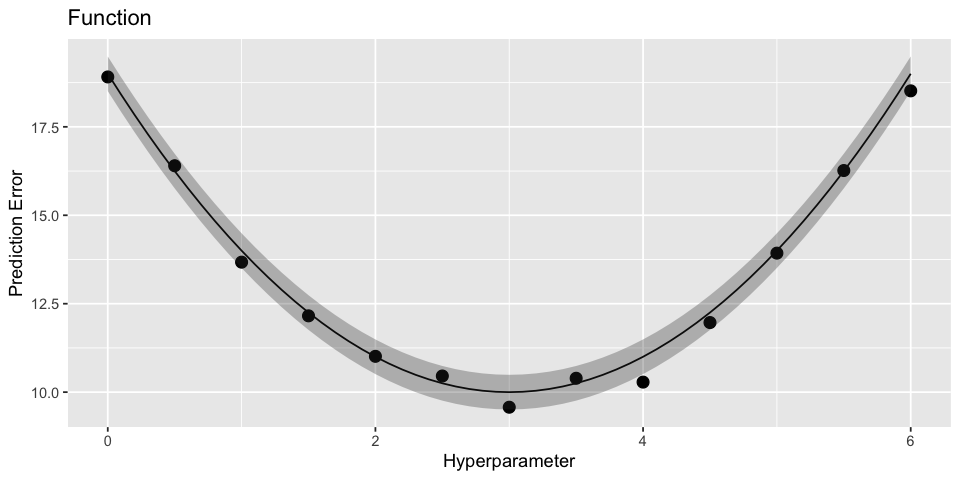

In [59]:
xeval <- seq(0, rlim, 0.5)
function.df <- data.frame(x=x, y=f(x, sd=0), lwr=f(x, sd=0)-1.96*f.sd, upr=f(x, sd=0)+1.96*f.sd)
points.df <- data.frame(x=xeval, y=f(xeval, sd=f.sd))
p <- ggplot(points.df, aes(x=x, y=y))+
    labs(x="Hyperparameter", y = "Prediction Error", title="Function")+
    geom_point(aes(), size=3)+
    geom_line(data=function.df)+
    geom_ribbon(data=function.df,aes(ymin=lwr,ymax=upr),alpha=0.3)+
    theme(legend.position="none")
p

In [51]:
length(seq(0, rlim, 0.5/5))

[1] 61

In [60]:
x <- seq(0, rlim, 0.5)
x.0 <- seq(0, rlim, 0.5/5)
n <- 10  # just needs to be bigger than n_lambda
X <- matrix(rep(x,each=n),nrow=n)
X.0 <- matrix(rep(x.0,each=n),nrow=n)
run.toy.example <- function(X, n.lambda.delta, alpha.dash){
    Y <- f(X, sd=f.sd)
    colnames(Y) <- X[1,]
    toy.raw <- gather(as.data.frame(Y)) %>% rename(Objective=value, x=key)
    toy.raw$x <- as.numeric(toy.raw$x)
    toy.df <- group_data(toy.raw, 'x', group_size=dim(X)[1])
    toy.result <- FilterTrials(toy.df, n.lambda.delta=n.lambda.delta, alpha.dash=alpha.dash)$H0 %>%
    select_lambda_star() %>%
    left_join(toy.raw %>% rename(Psi=Objective), by=c('Psi')) %>% select(c('ObservedMean', 'x')) %>% head(1)
    return(toy.result)
}

In [61]:
num.runs <- 100
alpha <- 0.05
first <- T

for(P in c(0.5)){
    seqboundary <- CalcPocockErrorAndSampleSize(n=c(5), alpha=alpha, P=P)
    alpha.dash <- seqboundary$alpha.dash
    n.lambda.delta <- seqboundary$n.delta
    for(i in 1:num.runs){
        rval <- run.toy.example(X,n.lambda.delta=n.lambda.delta,alpha.dash=alpha.dash)
        if(first){
            rval$Method = '5'
            toy.df <- as.data.frame(rval, stringsAsFactors = T)
            
            first <- F
        }else{
            toy.df <- add_row(toy.df, ObservedMean=rval$ObservedMean, x=rval$x, Method='5')
        }
        
    }
}

seqboundary <- CalcPocockErrorAndSampleSize(n=c(1), alpha=alpha)
alpha.dash <- seqboundary$alpha.dash
n.lambda.delta <- seqboundary$n.delta
for(i in 1:num.runs){
    rval <- run.toy.example(X.0,n.lambda.delta=n.lambda.delta,alpha.dash=alpha.dash)
    toy.df <- add_row(toy.df, ObservedMean=rval$ObservedMean, x=rval$x, Method='1')
}
toy.df$Expected <- f(toy.df$x, sd=0)

In [62]:
head(toy.df)

ObservedMean,x,Method,Expected
9.936001,3.0,5,10.00
9.858945,3.0,5,10.00
10.116156,3.0,5,10.00
10.074831,3.0,5,10.00
10.159027,3.5,5,10.25
10.085695,3.0,5,10.00


In [63]:
tail(toy.df)

,ObservedMean,x,Method,Expected
195,9.762874,2.6,1,10.16
196,9.637947,2.8,1,10.04
197,9.621799,2.9,1,10.01
198,9.783336,3.0,1,10.00
199,9.645296,3.2,1,10.04
200,9.607198,3.0,1,10.00


In [64]:
toy.df %>% group_by(Method) %>% summarise(MeanX=mean(x), VarX=var(x), MeanExp=mean(Expected), VarExp=var(Expected), Count=n())

Method,MeanX,VarX,MeanExp,VarExp,Count
1,2.979,0.07420101,10.0739,0.009290697,100
5,3.010,0.03020202,10.0300,0.006666667,100


Warning message:
“position_stack requires non-overlapping x intervals”

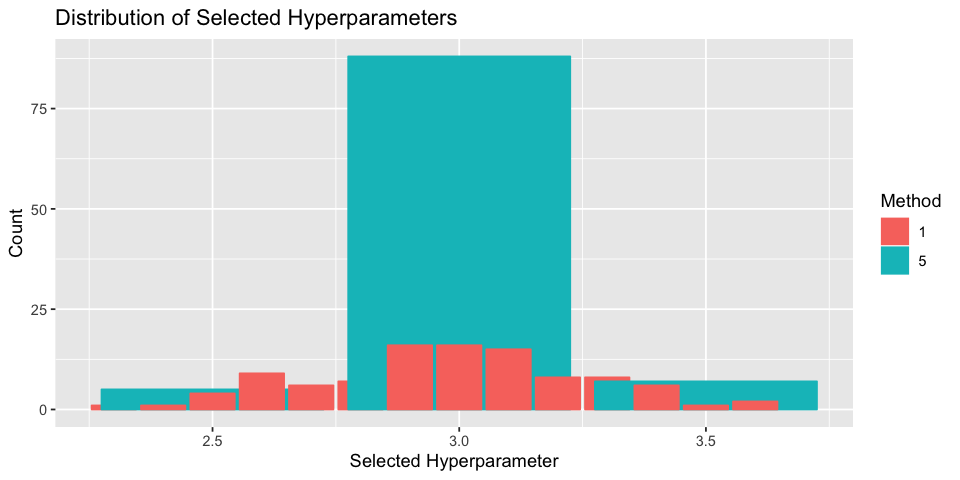

In [65]:
motivating.example.bar <- ggplot(toy.df, aes(x=x, color=Method, fill=Method)) +
                          geom_bar() +
                          labs(x="Selected Hyperparameter", y = "Count", title="Distribution of Selected Hyperparameters")
motivating.example.bar

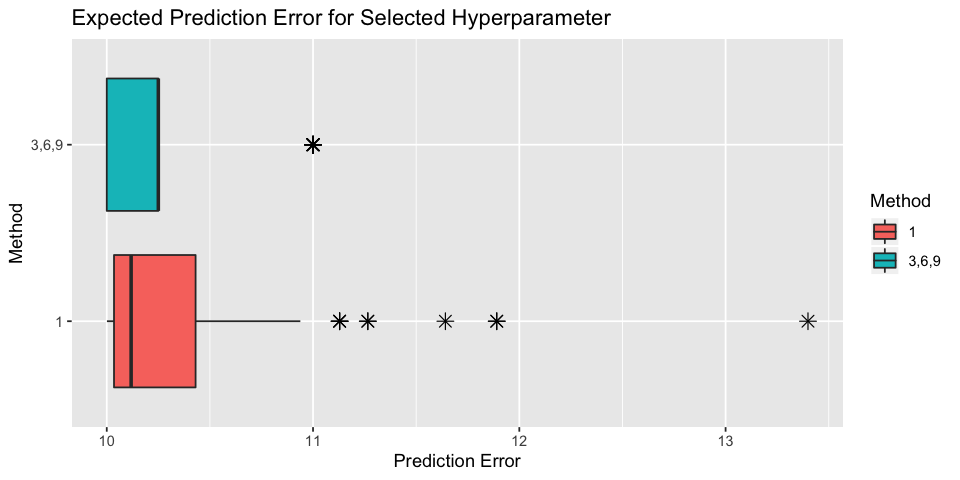

In [14]:
motivating.example.box <- ggplot(toy.df, aes(x=Method, y=f(x, sd=0), fill=Method)) + 
  geom_boxplot(outlier.colour="black", outlier.shape=8, outlier.size=3) +
  labs(y="Prediction Error", title="Expected Prediction Error for Selected Hyperparameter") +
  coord_flip()
motivating.example.box

# Definitions

In [110]:
K.values <- c(50, 100, 150)
n.lambda <- list('1'=c(1), '5'=c(5), '10'=c(10), '3,6,9'=c(3,6,9))
num.runs <- 200

# Cifar

In [78]:
results <- read.csv("./cifar10resnet/results.csv", header = T)
completed <- subset(results, Status == 'COMPLETED')
cifar <- group_data(completed, 'lr')

In [83]:
completed %>% group_by_at("lr") %>% summarise(count=n())

lr,count
0.05,25
0.06,25
0.07,25
0.08,25
0.09,25
0.10,15
0.30,1
0.50,1


In [76]:
unique(cifar$Lambda)

[1] 1 2 3 4 5

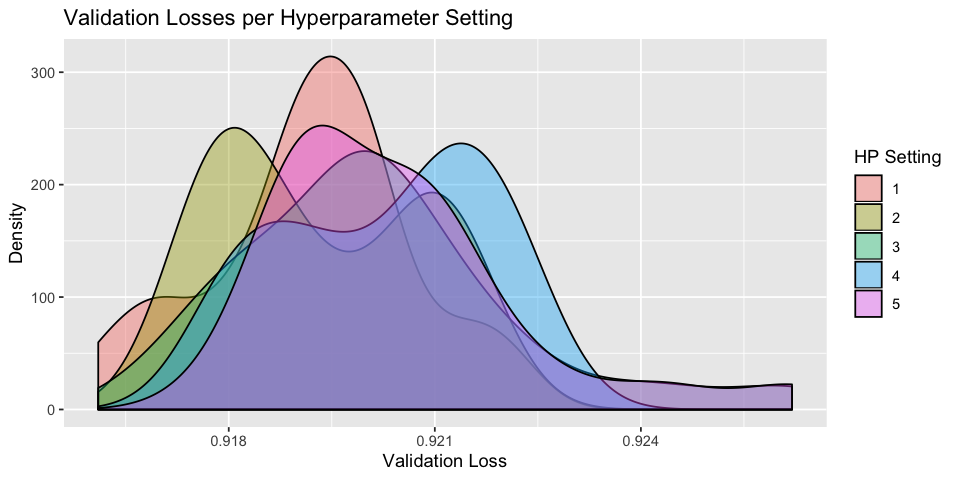

In [85]:
cifar.plot <- ggplot(subsample_trials(cifar, 25), aes(x=Psi, fill=factor(Lambda))) +
               geom_density(alpha=0.4) +
               labs(fill = "HP Setting", x="Validation Loss", y="Density", title="Validation Losses per Hyperparameter Setting")
cifar.plot

# MNIST

In [68]:
results <- read.csv("./mnistcnn/mnist-unshuffled-merged.csv", header = T)
completed <- subset(results, Status == 'COMPLETED')
mnist <- group_data(completed, 'dropout', testset="test_loss")

In [34]:
length(unique(mnist$Lambda))

[1] 592

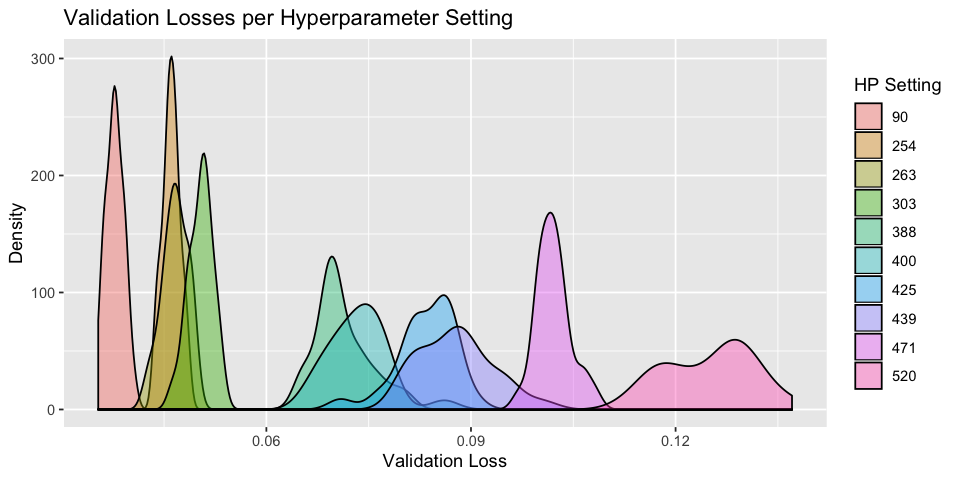

In [9]:
mnist.plot <- ggplot(subsample_trials(subsample_groups(mnist, 10), 25), aes(x=Psi, fill=factor(Lambda))) +
               geom_density(alpha=0.4) +
               labs(fill = "HP Setting", x="Validation Loss", y="Density", title="Validation Losses per Hyperparameter Setting")
mnist.plot

In [72]:
ggsave("figures/MNIST-density.pdf", plot=mnist.plot, width=8, height=4)

In [118]:
# With Wald
mnist.results <- list()
for(k in K.values) {
    mnist.results[[as.character(k)]] <- list()
    for(i in 1:length(n.lambda)) {
#         cat(paste("Running K=", k, " n.lambda=", paste(as.character(n.lambda[[names(n.lambda)[i]]]), sep="", collapse=""), "\n"))
        mnist.results[[as.character(k)]][[names(n.lambda)[i]]] <- EvalMetrics(tbl=mnist,
                                                                n.lambda=n.lambda[[names(n.lambda)[i]]],
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                P=0.5,
                                                                K=k)
    }
}
mnist.caption <- "Results for the MNIST Convolutional Neural Network hyperparameter optimization across 1000 independent simulations for each value of $K$."
TableCreator(mnist.results, caption=mnist.caption, label="mnist-results")

\begin{table}
\caption{Results for the MNIST Convolutional Neural Network hyperparameter optimization across 1000 independent simulations for each value of $K$.\label{tab:mnist-results}}
\begin{center}
\begin{tabular}{lccccc}
\toprule
$n_\lambda$ & 1 & 5 & 10 & 3,6,9 \\

\midrule
$K= 50 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.615 & 0.995 & 1 & 0.97 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 2.43 & 2.045 & 1.93 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.992 & 0.971 & 0.979 & 0.98 \\ 
Avg Evaluations & 50 & 250 & 500 & 165.945 \\ 

\midrule
$K= 100 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.51 & 0.995 & 1 & 0.96 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 3.06 & 2.47 & 2.375 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.995 & 0.979 & 0.985 & 0.986 \\ 
Avg Evaluations & 100 & 500 & 1000 & 318.6 \\ 

\midrule
$K= 150 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.385 & 0.99 & 0.995 & 0.955 \\ 
$\bar{|\mathcal{H}_

In [170]:
mnist.results <- list()
for(k in K.values) {
    mnist.results[[as.character(k)]] <- list()
    for(i in 1:length(n.lambda)) {
#         cat(paste("Running K=", k, " n.lambda=", paste(as.character(n.lambda[[names(n.lambda)[i]]]), sep="", collapse=""), "\n"))
        mnist.results[[as.character(k)]][[names(n.lambda)[i]]] <- EvalMetrics(tbl=mnist,
                                                                n.lambda=n.lambda[[names(n.lambda)[i]]],
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                P=0.5,
                                                                K=k)
    }
}
mnist.caption <- "Results for the MNIST Convolutional Neural Network hyperparameter optimization across 1000 independent simulations for each value of $K$."
TableCreator(mnist.results, caption=mnist.caption, label="mnist-results")

\begin{table}
\caption{Results for the MNIST Convolutional Neural Network hyperparameter optimization across 1000 independent simulations for each value of $K$.\label{tab:mnist-results}}
\begin{center}
\begin{tabular}{lccccc}
\toprule
$n_\lambda$ & 1 & 5 & 10 & 3,6,9 \\

\midrule
$K= 50 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.69 & 1 & 1 & 0.995 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 3.185 & 2.075 & 2.385 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.994 & 0.955 & 0.978 & 0.972 \\ 
Avg Evaluations & 50 & 250 & 500 & 175.26 \\ 

\midrule
$K= 100 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.44 & 1 & 1 & 1 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 4.055 & 3.085 & 3.26 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.994 & 0.969 & 0.979 & 0.977 \\ 
Avg Evaluations & 100 & 500 & 1000 & 334.68 \\ 

\midrule
$K= 150 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.38 & 1 & 1 & 0.99 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 5.51 

In [289]:
results.shuffled <- read.csv("./mnistcnn/mnist_with_test_set_merged.csv", header = T)
completed.shuffled <- subset(results.shuffled, Status == 'COMPLETED')
mnist.shuffled <- group_data(completed.shuffled, 'dropout', testset="test_loss")

# IMDB

In [68]:
imdb.csv <- read.csv("./imdblstm/imdb_results.csv", header = T)
imdb.csv$Objective <- 1.-imdb.csv$Objective+rnorm(nrow(imdb.csv), 0, 0.00001)
imdb.csv$test_error <- 1.-imdb.csv$test_acc
imdb <- group_data(imdb.csv, 'dropout_embedding', testset='test_error')

In [69]:
imdb.csv <- read.csv("./imdblstm/imdb_results.csv", header = T)

In [70]:
sum(!is.na(imdb.csv$test_acc))

[1] 15549

In [71]:
length(unique(imdb$Lambda))

[1] 553

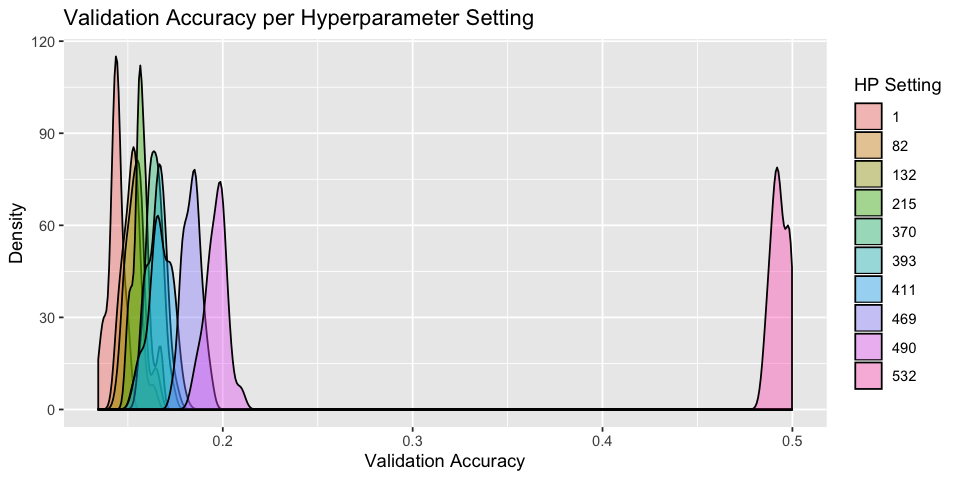

In [339]:
imdb.plot <- ggplot(subsample_trials(subsample_groups(imdb, 10), 25), aes(x=Psi, fill=factor(Lambda))) +
               geom_density(alpha=0.4) +
               labs(fill = "HP Setting", x="Validation Accuracy", y="Density", title="Validation Accuracy per Hyperparameter Setting")
imdb.plot

In [67]:
ggsave("figures/IMDB-density.pdf", plot=imdb.plot, width=8, height=4)

In [122]:
# With Wald
imdb.results <- list()
for(k in K.values) {
    imdb.results[[as.character(k)]] <- list()
    for(i in 1:length(n.lambda)) {
        imdb.results[[as.character(k)]][[names(n.lambda)[i]]] <- EvalMetrics(tbl=imdb,
                                                                n.lambda=n.lambda[[names(n.lambda)[i]]],
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                K=k)
    }
}
imdb.caption <- "Results for the IMDB LSTM hyperparameter optimization across 1000 independent simulations for each value of $K$."
TableCreator(imdb.results, caption=imdb.caption, label="imdb-results")

\begin{table}
\caption{Results for the IMDB LSTM hyperparameter optimization across 1000 independent simulations for each value of $K$.\label{tab:imdb-results}}
\begin{center}
\begin{tabular}{lccccc}
\toprule
$n_\lambda$ & 1 & 5 & 10 & 3,6,9 \\

\midrule
$K= 50 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.55 & 0.99 & 1 & 0.97 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 3.145 & 2.555 & 2.475 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.991 & 0.956 & 0.968 & 0.969 \\ 
Avg Evaluations & 50 & 250 & 500 & 168.885 \\ 

\midrule
$K= 100 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.38 & 0.985 & 1 & 0.97 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 4.21 & 3.19 & 3.085 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.994 & 0.967 & 0.978 & 0.979 \\ 
Avg Evaluations & 100 & 500 & 1000 & 325.335 \\ 

\midrule
$K= 150 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.34 & 1 & 1 & 0.98 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 5.425 & 4.42 & 3.79 \

In [38]:
imdb.results <- list()
for(k in K.values) {
    imdb.results[[as.character(k)]] <- list()
    for(i in 1:length(n.lambda)) {
        imdb.results[[as.character(k)]][[names(n.lambda)[i]]] <- EvalMetrics(tbl=imdb,
                                                                n.lambda=n.lambda[[names(n.lambda)[i]]],
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                K=k)
    }
}
imdb.caption <- "Results for the IMDB LSTM hyperparameter optimization across 1000 independent simulations for each value of $K$."
TableCreator(imdb.results, caption=imdb.caption, label="imdb-results")

\begin{table}
\caption{Results for the IMDB LSTM hyperparameter optimization across 1000 independent simulations for each value of $K$.\label{tab:imdb-results}}
\begin{center}
\begin{tabular}{lccccc}
\toprule
$n_\lambda$ & 1 & 5 & 10 & 3,6,9 \\

\midrule
$K= 50 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.508 & 0.996 & 1 & 0.994 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 4.648 & 2.93 & 3.494 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.99 & 0.925 & 0.961 & 0.949 \\ 
Avg Evaluations & 50 & 250 & 500 & 189.072 \\ 

\midrule
$K= 100 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.404 & 1 & 0.998 & 0.996 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 6.876 & 4.068 & 5.04 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.994 & 0.941 & 0.969 & 0.959 \\ 
Avg Evaluations & 100 & 500 & 1000 & 358.404 \\ 

\midrule
$K= 150 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.324 & 0.998 & 1 & 1 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 8.89 & 5.182 & 

In [314]:
imdb.csv <- read.csv("./imdblstm/imdb_results_shuffled.csv", header = T)
imdb.csv$Objective <- 1.-imdb.csv$Objective+rnorm(nrow(imdb.csv), 0, 0.000000001)
imdb.csv$test_error <- 1.-imdb.csv$test_acc
imdb.shuffled <- group_data(imdb.csv, 'dropout_embedding', testset='test_error')

# Boston

In [13]:
boston.csv <- read.csv("./bostongbrt/boston-seed12-merged.csv", header = T)
boston.completed <- subset(boston.csv, Status == 'COMPLETED')
boston.completed <- boston.completed[order(boston.completed$Trial.ID),]
boston <- group_data(boston.completed, 'subsample', testset="test_mse")

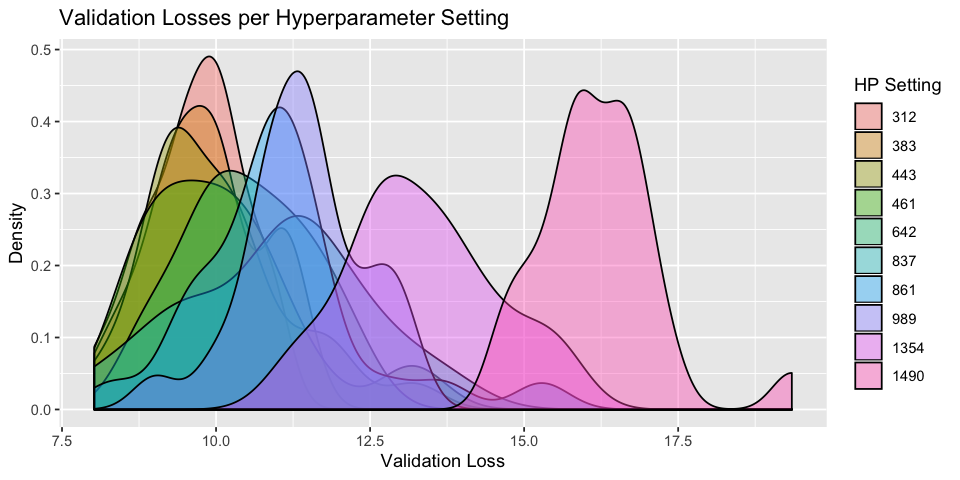

In [61]:
boston.plot <- ggplot(subsample_trials(subsample_groups(boston, 10), 25), aes(x=Psi, fill=factor(Lambda))) +
               geom_density(alpha=0.4) +
               labs(fill = "HP Setting", x="Validation Loss", y="Density", title="Validation Losses per Hyperparameter Setting")
boston.plot

In [62]:
ggsave("figures/Boston-density.pdf", plot=boston.plot, width=8, height=4)

In [40]:
boston.results <- list()
for(k in K.values) {
    boston.results[[as.character(k)]] <- list()
    for(i in 1:length(n.lambda)) {
        boston.results[[as.character(k)]][[names(n.lambda)[i]]] <- EvalMetrics(tbl=boston,
                                                                n.lambda=n.lambda[[names(n.lambda)[i]]],
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                K=k)
    }
}
boston.caption <- "Results for the Boston Housing gradient boosted regression tree hyperparameter optimization across 1000 independent simulations for each value of $K$."
TableCreator(boston.results, caption=boston.caption, label="boston-results")

\begin{table}
\caption{Results for the Boston Housing gradient boosted regression tree hyperparameter optimization across 1000 independent simulations for each value of $K$.\label{tab:boston-results}}
\begin{center}
\begin{tabular}{lccccc}
\toprule
$n_\lambda$ & 1 & 5 & 10 & 3,6,9 \\

\midrule
$K= 50 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.15 & 1 & 0.998 & 0.998 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 21.43 & 12.806 & 15.35 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.983 & 0.583 & 0.759 & 0.707 \\ 
Avg Evaluations & 50 & 250 & 500 & 304.632 \\ 

\midrule
$K= 100 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.076 & 1 & 1 & 1 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 38.132 & 23.212 & 26.472 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.991 & 0.625 & 0.776 & 0.743 \\ 
Avg Evaluations & 100 & 500 & 1000 & 574.704 \\ 

\midrule
$K= 150 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.048 & 1 & 1 & 1 \\ 
$\bar{|\mat

In [290]:
results.shuffled <- read.csv("./bostongbrt/boston-shuffled-merged.csv", header = T)
completed.shuffled <- subset(results.shuffled, Status == 'COMPLETED')
boston.shuffled <- group_data(completed.shuffled, 'subsample', testset="test_mse")

# Mean and Variance across repeated runs as compared to standard method

In [347]:
meanvar.num.runs <- 10
meanvar.results <- list()
datasets <- list('Boston'=boston, 'MNIST'=mnist, 'IMDB'=imdb)
meanvar.K <- list('Boston'=c(50, 100, 150), 'MNIST'=c(50, 100, 150), 'Cartpole'=c(55), 'IMDB'=c(50, 100, 150))
adjusted.K <- list()

In [348]:
for(dataset.name in c('MNIST', 'IMDB', 'Boston')){
    meanvar.results[[dataset.name]] <- list()
    meanvar.results[[dataset.name]][['3,6,9']] <- list()
    for(k in meanvar.K[[dataset.name]]) {
        meanvar.results[[dataset.name]][['3,6,9']][[as.character(k)]] <- EvalMetrics(tbl=datasets[[dataset.name]],
                                                                    n.lambda=c(3,6,9),
                                                                    alpha=0.05,
                                                                    num.runs=meanvar.num.runs,
                                                                    K=k,
                                                                    P=0.5,
                                                                    testset=T)
    }

    adjusted.K[[dataset.name]] <- list()
    for (k in names(meanvar.results[[dataset.name]][['3,6,9']])) {
        adjusted.K[[dataset.name]][[k]] <- ceiling(meanvar.results[[dataset.name]][['3,6,9']][[k]][['Avg Evaluations']])
        cat(ifelse(adjusted.K[[dataset.name]][[k]] > length(unique(datasets[[dataset.name]]$Lambda)), "not enough trials", ""))
    }

    meanvar.results[[dataset.name]][['1']] <- list()
    for(k in meanvar.K[[dataset.name]]) {
        meanvar.results[[dataset.name]][['1']][[as.character(adjusted.K[[dataset.name]][[as.character(k)]])]] <- EvalMetrics(tbl=datasets[[dataset.name]],
                                                                                    n.lambda=c(1),
                                                                                    alpha=0.05,
                                                                                    num.runs=meanvar.num.runs,
                                                                                    K=adjusted.K[[dataset.name]][[as.character(k)]],
                                                                                    testset=T)
    }
}


In [349]:
TableMeanVar(meanvar.results, adj.k=adjusted.K)

\begin{table}
\footnotesize
\caption{\label{tab:meanvar-results}}
\begin{center}
\begin{tabular}{lccc}
\toprule
\multicolumn{1}{c}{} & \multicolumn{1}{c}{$n_\lambda = 1$}   & \multicolumn{2}{c}{$n_\lambda = (3,6,9)$}\\
& & $\lambda$ sampled & $\lambda$ best \\
\midrule
MNIST& & & \\
 &\multicolumn{1}{c}{$K= 172 $}&\multicolumn{2}{c}{$K=50$}\\
Valid &0(0)&0(0)&0(0)\\
Test &0.027(3.671e-07)&0.0276(1.151e-06)&0.0271(7.161e-07)\\
 &\multicolumn{1}{c}{$K= 342 $}&\multicolumn{2}{c}{$K=100$}\\
Valid &0(0)&0(0)&0(0)\\
Test &0.0267(3.387e-07)&0.0272(3.009e-07)&0.0266(3.066e-07)\\
 &\multicolumn{1}{c}{$K= 494 $}&\multicolumn{2}{c}{$K=150$}\\
Valid &0(0)&0(0)&0(0)\\
Test &0.0265(7.146e-07)&0.0271(5.920e-07)&0.0267(3.990e-07)\\
\midrule
IMDB& & & \\
 &\multicolumn{1}{c}{$K= 183 $}&\multicolumn{2}{c}{$K=50$}\\
Valid &0.1(0)&0.1(0)&0.1(0)\\
Test &NA(  NA)&NA(  NA)&NA(  NA)\\
 &\multicolumn{1}{c}{$K= 376 $}&\multicolumn{2}{c}{$K=100$}\\
Valid &0.1(0)&0.2(0)&0.1(0)\\
Test &NA(  NA)&NA(  NA)&NA(  NA)\\

In [340]:
head(imdb)

Lambda,Psi,PsiTest
1,0.1448,0.14444
1,0.1446,0.14716
1,0.1442,0.15388
1,0.1344,0.14676
1,0.1500,0.14408
1,0.1386,0.14592


In [330]:
imdb %>% group_by(Lambda) %>% summarise(meanPsi=mean(Psi)) %>% slice(which.min(meanPsi))

Lambda,meanPsi
1,0.146392


In [146]:
meanvar.num.runs <- 5000
meanvar.results <- list()
datasets <- list('Boston'=boston, 'MNIST'=mnist, 'IMDB'=imdb)
meanvar.K <- list('Boston'=c(150), 'MNIST'=c(150), 'Cartpole'=c(55), 'IMDB'=c(150))
adjusted.K <- list()

In [147]:
for(dataset.name in c('MNIST', 'IMDB', 'Boston')){
    meanvar.results[[dataset.name]] <- list()
    meanvar.results[[dataset.name]][['3,6,9']] <- list()
    for(k in meanvar.K[[dataset.name]]) {
        meanvar.results[[dataset.name]][['3,6,9']][[as.character(k)]] <- EvalMetricsFullResults(tbl=datasets[[dataset.name]],
                                                                    n.lambda=c(3,6,9),
                                                                    alpha=0.05,
                                                                    num.runs=meanvar.num.runs,
                                                                    K=k,
                                                                    P=0.5,
                                                                    testset=T)
    }

    adjusted.K[[dataset.name]] <- list()
    for (k in names(meanvar.results[[dataset.name]][['3,6,9']])) {
        adjusted.K[[dataset.name]][[k]] <- ceiling(meanvar.results[[dataset.name]][['3,6,9']][[k]][['Avg Evaluations']])
        cat(ifelse(adjusted.K[[dataset.name]][[k]] > length(unique(datasets[[dataset.name]]$Lambda)), "not enough trials", ""))
    }

    meanvar.results[[dataset.name]][['1']] <- list()
    for(k in meanvar.K[[dataset.name]]) {
        meanvar.results[[dataset.name]][['1']][[as.character(adjusted.K[[dataset.name]][[as.character(k)]])]] <- EvalMetricsFullResults(tbl=datasets[[dataset.name]],
                                                                                    n.lambda=c(1),
                                                                                    alpha=0.05,
                                                                                    num.runs=meanvar.num.runs,
                                                                                    K=adjusted.K[[dataset.name]][[as.character(k)]],
                                                                                    testset=T)
    }
}


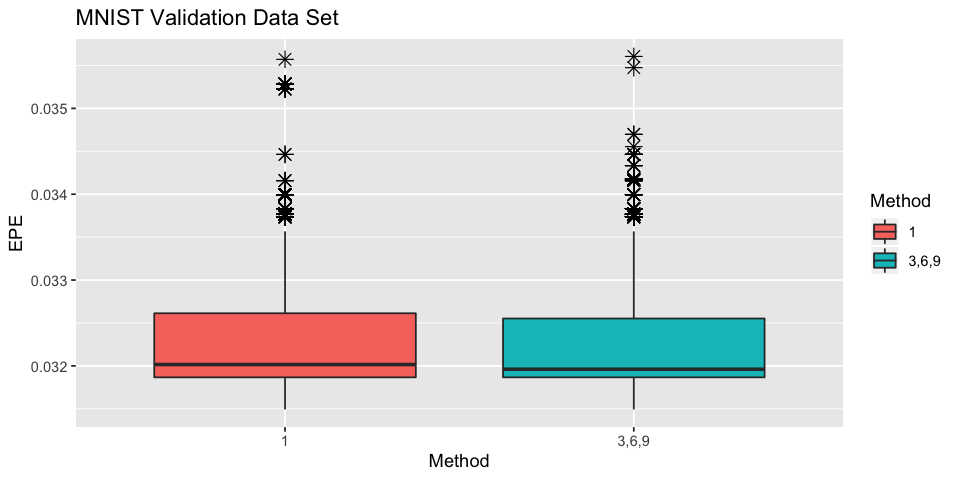

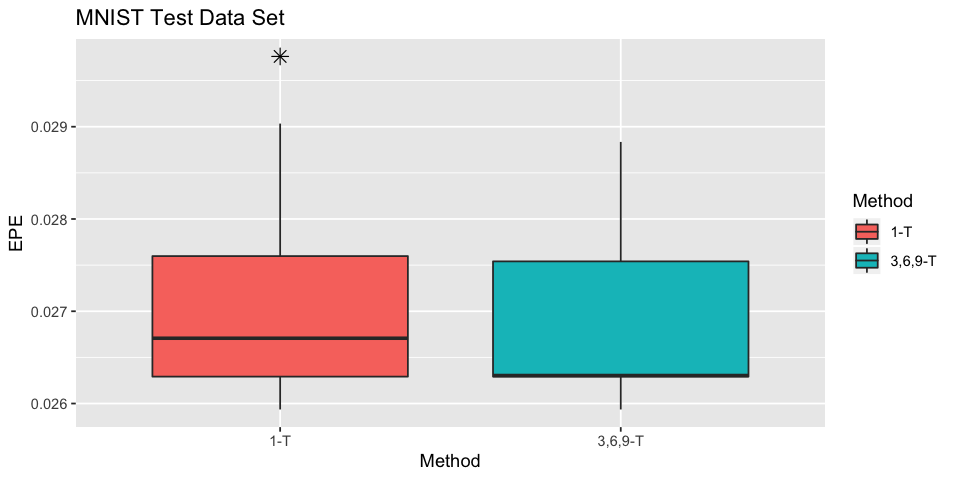

In [150]:
par(mfrow=c(1,1))
dataset = "MNIST"
rval = rbind(tibble(EPE=meanvar.results[[dataset]][['3,6,9']][['150']][['E(\\Psi(\\lambda^*))']], Method='3,6,9'),
             tibble(EPE=meanvar.results[[dataset]][['1']][[names(meanvar.results[[dataset]][['1']])]][['E(\\Psi(\\lambda^*))']], Method='1'))
valid.boxplot <- ggplot(rval, aes(x=Method, y=EPE, fill=Method)) + 
                          geom_boxplot(outlier.colour="black", outlier.shape=8, outlier.size=3) +
                          labs(y="EPE", title=paste(dataset, "Validation Data Set"))
valid.boxplot
ggsave(paste("figures/", dataset, "-validation.pdf", sep=""), plot=valid.boxplot, width=8, height=4)
rval = rbind(tibble(EPE=meanvar.results[[dataset]][['3,6,9']][['150']][['E(\\Psi^T(\\lambda^*))']], Method='3,6,9-T'),
             tibble(EPE=meanvar.results[[dataset]][['1']][[names(meanvar.results[[dataset]][['1']])]][['E(\\Psi^T(\\lambda^*))']], Method='1-T'))
test.boxplot <- ggplot(rval, aes(x=Method, y=EPE, fill=Method)) + 
                      geom_boxplot(outlier.colour="black", outlier.shape=8, outlier.size=3) +
                      labs(y="EPE", title=paste(dataset, "Test Data Set"))
ggsave(paste("figures/", dataset, "-test.pdf", sep=""), plot=test.boxplot, width=8, height=4)
test.boxplot

### With Cross Validation

In [315]:
meanvar.num.runs <- 100
datasets.shuffled <- list('MNIST'=mnist.shuffled, 'Boston'=boston.shuffled, 'IMDB'=imdb.shuffled)

In [318]:
for(dataset.name in c('MNIST', 'IMDB', 'Boston')){    
    meanvar.results[[dataset.name]][['3,6,9-shuffled']] <- list()
    for(k in meanvar.K[[dataset.name]]) {
        meanvar.results[[dataset.name]][['3,6,9-shuffled']][[as.character(k)]] <- EvalMetrics(tbl=datasets.shuffled[[dataset.name]],
                                                                    n.lambda=c(3,6,9),
                                                                    alpha=0.05,
                                                                    num.runs=meanvar.num.runs,
                                                                    K=k,
                                                                    P=0.5,
                                                                    testset=T)
    }
}


In [319]:
TableMeanVarCV(meanvar.results, adj.k=adjusted.K)

\begin{table}
\footnotesize
\caption{\label{tab:meanvar-results}}
\begin{center}
\begin{tabular}{lcccc}
\toprule
\multicolumn{1}{c}{} & \multicolumn{1}{c}{$n_\lambda = 1$}   & \multicolumn{2}{c}{$n_\lambda = (3,6,9)$} & \multicolumn{1}{c}{$n_\lambda = (3,6,9)$-CV}\\
& & $\lambda$ sampled & $\lambda$ best & $\lambda$ best \\
\midrule
MNIST& & & & \\
 &\multicolumn{1}{c}{$K= 176 $}&\multicolumn{3}{c}{$K=50$}\\
Valid &0.0326(6.721e-07)&0.0333(1.503e-06)&0.0329(1.122e-06)&0.033(1.534e-06)\\
Test &0.0269(5.335e-07)&0.0274(9.411e-07)&0.0271(7.729e-07)&0.0281(1.286e-06)\\
 &\multicolumn{1}{c}{$K= 339 $}&\multicolumn{3}{c}{$K=100$}\\
Valid &0.0324(5.935e-07)&0.033(1.071e-06)&0.0324(5.383e-07)&0.0326(8.896e-07)\\
Test &0.0269(5.979e-07)&0.0272(6.937e-07)&0.0268(4.529e-07)&0.0277(1.196e-06)\\
 &\multicolumn{1}{c}{$K= 495 $}&\multicolumn{3}{c}{$K=150$}\\
Valid &0.0322(4.669e-07)&0.0327(6.817e-07)&0.0321(2.913e-07)&0.0322(1.019e-06)\\
Test &0.0267(5.125e-07)&0.0271(5.381e-07)&0.0267(4.425e-07)&0.0

# Different sequential boundaries

In [119]:
seqboundary.num.runs <- 500
seqboundary.results <- list()
datasets <- list('Boston'=boston, 'MNIST'=mnist, 'IMDB'=imdb)
seqboundary.K <- list('Boston'=c(150), 'MNIST'=c(150), 'IMDB'=c(150))

In [120]:
for(dataset.name in c('MNIST', 'IMDB', 'Boston')){
    seqboundary.results[[dataset.name]] <- list()
    seqboundary.results[[dataset.name]][['0.25']] <- list()
    seqboundary.results[[dataset.name]][['0.5']] <- list()
    seqboundary.results[[dataset.name]][['0.75']] <- list()
    seqboundary.results[[dataset.name]][['1.']] <- list()
    for(K in seqboundary.K[[dataset.name]]) {
        for(P in names(seqboundary.results[[dataset.name]])){
            seqboundary.results[[dataset.name]][[P]][[as.character(K)]] <- EvalMetrics(tbl=datasets[[dataset.name]],
                                                                        n.lambda=c(3,6,9),
                                                                        alpha=0.05,
                                                                        num.runs=seqboundary.num.runs,
                                                                        K=K,
                                                                        P=as.numeric(P),
                                                                        testset=T) 
        }

    }
}

In [123]:
TableSeqBoundary(results=seqboundary.results)

\begin{table}
\footnotesize
\caption{\label{tab:}}
\begin{center}
\begin{tabular}{lcccc}
\toprule
$P$ & 0.25 & 0.5 & 0.75 & 1. \\

\midrule
MNIST& & & & \\

\midrule
$K= 150 $ &&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.994 & 0.996 & 0.998 & 0.998 \\ 
$\bar{|\mathcal{H}_0|}$ & 4.614 & 4.08 & 3.988 & 3.962 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.976 & 0.979 & 0.98 & 0.98 \\ 
Avg Evaluations & 494.898 & 495.57 & 500.106 & 510.21 \\ 
$\mathbb{E}_{\mathcal{HPO}}\{\tau_{\hat{\lambda^*}}\}$($\mathrm{Var}_{\mathcal{HPO}}\{\tau_{\hat{\lambda^*}}\}$) & 0.032(3.743e-07) & 0.032(3.440e-07) & 0.032(3.621e-07) & 0.032(4.339e-07) \\ 
$\mathbb{E}_{\mathcal{HPO}}\{\tau^T_{\hat{\lambda^*}}\}$($\mathrm{Var}_{\mathcal{HPO}}\{\tau^T_{\hat{\lambda^*}}\}$) & 0.027(4.217e-07) & 0.027(4.432e-07) & 0.027(4.109e-07) & 0.027(4.455e-07) \\ 

\midrule
IMDB& & & & \\

\midrule
$K= 150 $ &&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 1 & 0.996 & 1 & 0.996 \\ 
$\bar{|\ma

# Type I error with real data

In [109]:
type.I.error <- list()
for(dset.name in c('MNIST', 'IMDB', 'Boston')){
    type.I.error[[dset.name]] <- list()
    for(n in c(3, 5, 10)){
        K <- floor(25/n)
        alpha <- 0.05
        num.runs <- 200
        H0.size <- rep(NA, num.runs)
        for(i in 1:num.runs){
            this.Lambda <- sample(length(unique(datasets[[dset.name]]$Lambda)), 1)
            df <- filter(datasets[[dset.name]], Lambda==this.Lambda)
            df$Lambda <- sample(c(rep(1:K, each=n), rep(K, 25-K*n)), replace=F)
            filtered.df <- filter_by_anova(df=df, alpha=alpha, verbose=F)
            H0.size[i] <- length(unique(filtered.df$Lambda))
        }
        type.I.error[[dset.name]][[as.character(n)]] <- mean(H0.size<K)
    }
}
type.I.error

Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm

$MNIST
$MNIST$`3`
[1] 0.035

$MNIST$`5`
[1] 0.07

$MNIST$`10`
[1] 0.035


$IMDB
$IMDB$`3`
[1] 0.08

$IMDB$`5`
[1] 0.04

$IMDB$`10`
[1] 0.025


$Boston
$Boston$`3`
[1] 0.06

$Boston$`5`
[1] 0.04

$Boston$`10`
[1] 0.035

In [112]:
for(dset.name in c('MNIST', 'IMDB', 'Boston')){
    K <- floor(25/12)
    alpha <- 0.05
    num.runs <- 200
    H0.size <- rep(NA, num.runs)
    for(i in 1:num.runs){
        this.Lambda <- sample(length(unique(datasets[[dset.name]]$Lambda)), 1)
        df <- filter(datasets[[dset.name]], Lambda==this.Lambda)
        df$Lambda <- sample(c(rep(1:K, each=n), rep(K, 25-K*n)), replace=F)
        filtered.df <- FilterTrials(tbl=df, n.lambda=c(3,6,9), alpha=alpha)$H0
        H0.size[i] <- length(unique(filtered.df$Lambda))
    }
    type.I.error[[dset.name]][['3,6,9']] <- mean(H0.size<K)
}
type.I.error

Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm

$MNIST
$MNIST$`3`
[1] 0.035

$MNIST$`5`
[1] 0.07

$MNIST$`10`
[1] 0.035

$MNIST$`3,6,9`
[1] 0.025


$IMDB
$IMDB$`3`
[1] 0.08

$IMDB$`5`
[1] 0.04

$IMDB$`10`
[1] 0.025

$IMDB$`3,6,9`
[1] 0.04


$Boston
$Boston$`3`
[1] 0.06

$Boston$`5`
[1] 0.04

$Boston$`10`
[1] 0.035

$Boston$`3,6,9`
[1] 0.035

# Distribution of validation losses

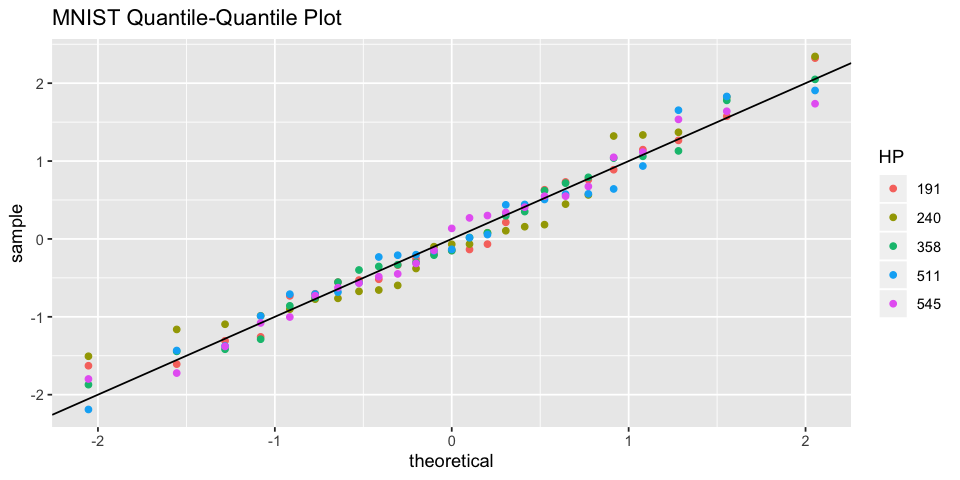

In [73]:
p <- ggplot(subsample_trials(subsample_groups(mnist, 5), 25) %>% mutate(Resids=scale(Psi)),
            aes(sample = Resids, col=factor(Lambda))) + stat_qq() + geom_abline() + labs(col='HP', title="MNIST Quantile-Quantile Plot")
p
ggsave("figures/MNIST-qqplot.png", plot=p, width=8, height=4)

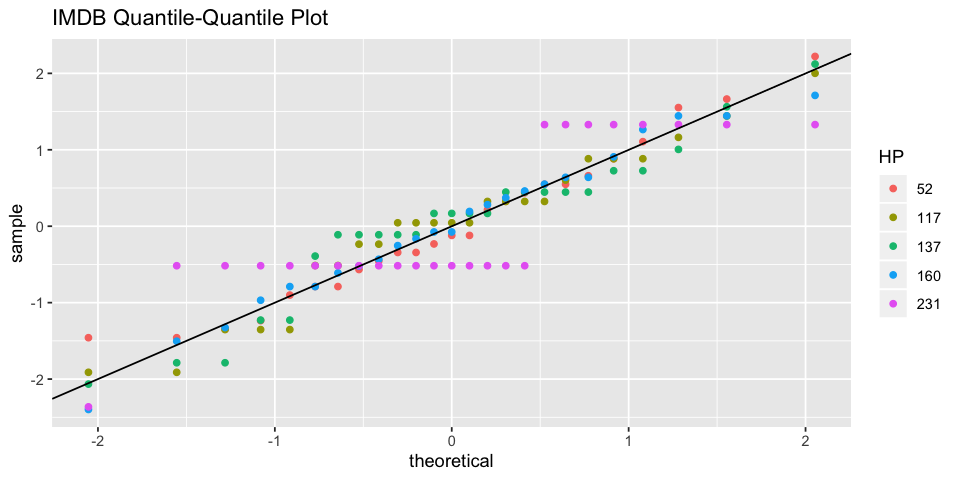

In [74]:
p <- ggplot(subsample_trials(subsample_groups(imdb, 5), 25) %>% mutate(Resids=scale(Psi)),
            aes(sample = Resids, col=factor(Lambda))) + stat_qq() + geom_abline() + labs(col='HP', title="IMDB Quantile-Quantile Plot")
p
ggsave("figures/IMDB-qqplot.png", plot=p, width=8, height=4)

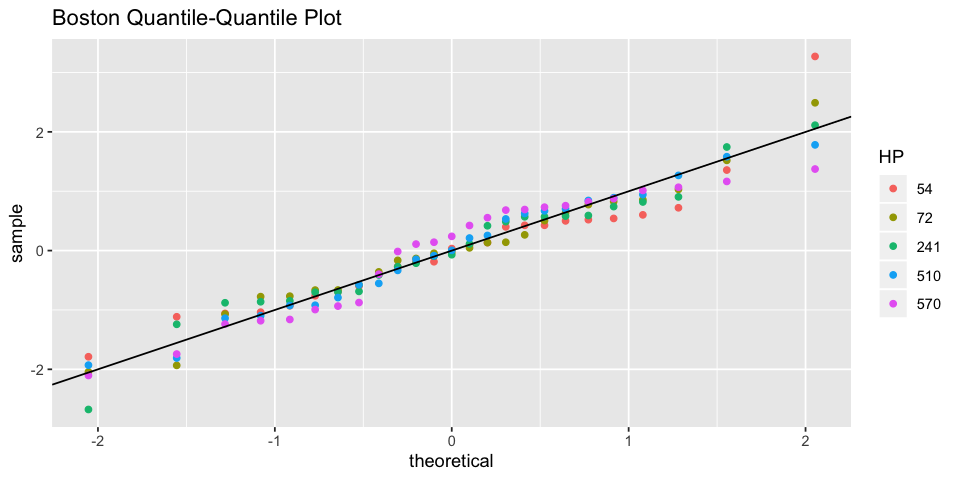

In [75]:
p <- ggplot(subsample_trials(subsample_groups(mnist, 5), 25) %>% mutate(Resids=scale(Psi)),
            aes(sample = Resids, col=factor(Lambda))) + stat_qq() + geom_abline() + labs(col='HP', title="Boston Quantile-Quantile Plot")
p
ggsave("figures/Boston-qqplot.png", plot=p, width=8, height=4)